# HSBC Mayweek Hackathon


## In Depth : Understanding USDINR NDF Orderbook Microstructure

The electronic Non-Deliverable Forwards market has grown over the past 2 years on EBS, the primary market for FX. Electronic liquidity traded inter-bank has gradually increased. Recently, the platform has opened to non-bank market participants. As a result, understanding the NDF price formation process in the presence of high frequency participants has become increasingly important as a Tier1 bank market-maker operating in the electronic market. In the analysis below, we build a supervised learning model , predicting the direction of the next price variation given a set of features, engineered from market orderbook data. The currency pair is the Indian rupee traded against US dollar.   Our goal is to build a predictive model to answer the following question

$$ \textit{The next time the price moves will it go up or down?}$$


## Fetch and plot historical USDINR Non Deliverable Forwards prices  

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 100

from_date = '2017.09.15'
to_date = '2017.09.30'
start_time = '03:00'
end_time = '15:00'

sym = '`USDINR'
site = "`LOH"

# load data from csv file (stratpy not available)
prices_raw = pd.read_csv("./Prices_raw.csv")

# parse timestamps correctly
for t in [u'date' , u'ebsMarketUpdateTime', u'feedHandlerPublishTime', u'feedHandlerReceiveTime', u'eventCaptureTime']:
    prices_raw[t] = pd.to_datetime(prices_raw[t])
    
print("First three rows of raw data")
prices_raw.head(3)

First three rows of raw data


,Unnamed: 0,index,date,sym,time,siteCode,instrument,status,ebsReferenceTime,ebsMarketUpdateTime,feedHandlerReceiveTime,feedHandlerPublishTime,eventCaptureTime,bid,ask,paid,given,bidRegular,askRegular,regularSize,bid2,bid3,bidSize1,bidSize2,bidSize3,numberBidMaker1,numberBidMaker2,numberBidMaker3,ask2,ask3,askSize1,askSize2,askSize3,numberAskMaker1,numberAskMaker2,numberAskMaker3
0,0,0,2017-09-15,USDINR,0 days 03:00:15.501000000,LOH,USDINR1M=EBSNDF,ok,NaN,2017-09-15 03:00:15.341,2017-09-15 03:00:15.341,2017-09-15 03:00:15.341,2017-09-15 03:00:15.362,64.36,64.37,NaN,0.0,NaN,NaN,NaN,64.33,64.31,1000000,1000000,1000000,1,1,1,64.405,64.520,1000000,1000000,22000000,1,1,1
1,1,1,2017-09-15,USDINR,0 days 03:00:15.901000000,LOH,USDINR1M=EBSNDF,ok,NaN,2017-09-15 03:00:15.841,2017-09-15 03:00:15.841,2017-09-15 03:00:15.841,2017-09-15 03:00:15.862,64.36,64.37,NaN,0.0,NaN,NaN,NaN,64.33,64.31,1000000,1000000,1000000,1,1,1,64.400,64.405,1000000,1000000,1000000,1,1,1
2,2,2,2017-09-15,USDINR,0 days 03:00:24.706000000,LOH,USDINR1M=EBSNDF,ok,NaN,2017-09-15 03:00:24.594,2017-09-15 03:00:24.594,2017-09-15 03:00:24.594,2017-09-15 03:00:24.635,64.36,64.37,NaN,0.0,NaN,NaN,NaN,64.33,64.31,1000000,1000000,1000000,1,1,1,64.400,64.410,1000000,1000000,1000000,1,1,1


### Timestamp Information

- date : day the update happened
- time : final time data was written to database
- ebsMarketUpdateTime : market updates
- feedHandlerPublishTime : data was published by feedhandler
- feedHandlerReceiveTime : data was first received by feedhandler
- eventCaptureTime : N/A

in theory 

                ebsMarketUpdateTime < feedHandlerReceiveTime < feedHandlerPublishTime

In [3]:
T = [u'date' , u'time' , u'ebsMarketUpdateTime', u'feedHandlerPublishTime', u'feedHandlerReceiveTime', u'eventCaptureTime']
timeDeltas = prices_raw[T]
timeDeltas['marketLatency'] = timeDeltas['feedHandlerReceiveTime'] - timeDeltas['ebsMarketUpdateTime']
timeDeltas['processLatency'] = timeDeltas['feedHandlerPublishTime'] - timeDeltas['feedHandlerReceiveTime']

timeDeltas[['marketLatency','processLatency',]].describe().T[['mean','std','max']]

,mean,std,max
marketLatency,0 days 00:00:00.000202,0 days 00:00:00.000415,0 days 00:00:00.017000
processLatency,0 days 00:00:00.000097,0 days 00:00:00.000308,0 days 00:00:00.021000


### Numerical Information

- index : sequence number for update
- bid,bid2,bid3 : prices people are willing to buy at. (Ruppees per Dollar)
- bidSize,bidSize2,bidSize3 : volumes people are willing to buy. (in Dollars)
- ask,ask2,ask3 : prices people are willing to sell at. (Ruppees per Dollar)
- askSize,askSize2,askSize3 : volumes people are willing to sell. (in Dollars)
- paid : last price someone paid on the ask side to trade. (Ruppees per Dollar)
- given : last price someone paid on the bid side to trade. (Ruppees per Dollar)

*** note the given data looks a bit odd?

In [4]:
N=[u'index', u'bid', u'ask', u'paid', u'given', u'bid2', u'bid3', u'bidSize1',\
   u'bidSize2', u'bidSize3', u'ask2', u'ask3', u'askSize1',u'askSize2', u'askSize3']

prices_raw[N].describe().T

,count,mean,std,min,25%,50%,75%,max
index,231154.0,1.155765e+05,6.672856e+04,0.000,57788.250,115576.500,173364.750,2.311530e+05
bid,231154.0,6.528029e+01,5.578074e-01,64.215,64.930,65.345,65.705,6.619000e+01
ask,231154.0,6.529080e+01,5.588692e-01,64.220,64.940,65.360,65.720,6.625000e+01
paid,6207.0,6.530812e+01,5.544746e-01,64.220,64.985,65.350,65.745,6.619500e+01
given,200740.0,1.883762e+00,1.093503e+01,0.000,0.000,0.000,0.000,6.619000e+01
bid2,231154.0,6.518508e+01,2.471577e+00,0.000,64.915,65.340,65.700,6.618000e+01
bid3,231154.0,6.495080e+01,4.564042e+00,0.000,64.885,65.335,65.690,6.617500e+01
bidSize1,231154.0,2.705962e+06,2.804288e+06,1000000.000,1000000.000,2000000.000,3000000.000,6.500000e+07
bidSize2,231154.0,4.264624e+06,4.190954e+06,0.000,2000000.000,3000000.000,5000000.000,7.300000e+07
bidSize3,231154.0,4.082067e+06,4.296730e+06,0.000,2000000.000,3000000.000,5000000.000,7.200000e+07


Let's plot an orderbook snapshot.

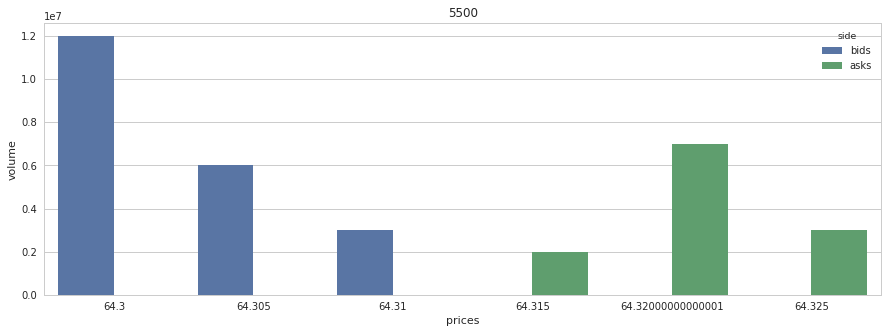

In [5]:
snapshot = prices_raw.iloc[5500]
orderbook = pd.DataFrame([{'prices':snapshot['bid'],'volume': snapshot['bidSize1'], 'side': 'bids'},
                            {'prices':snapshot['bid2'],'volume': snapshot['bidSize2'], 'side': 'bids'},
                            {'prices':snapshot['bid3'],'volume': snapshot['bidSize3'], 'side': 'bids'},
                            {'prices':snapshot['ask'],'volume': snapshot['askSize1'], 'side' : 'asks'},
                            {'prices':snapshot['ask2'],'volume': snapshot['askSize2'], 'side' : 'asks'},
                            {'prices':snapshot['ask3'],'volume': snapshot['askSize3'], 'side' : 'asks'}])

plt.figure(figsize=(15,5))
ax = sns.barplot(x="prices", y="volume", data=orderbook, hue = 'side')
ax.set_title(snapshot.name)
plt.show()

## Data pre-processing

We keep a subset of columns and index the dataframe by _feedHandlerReceiveTime_

In [6]:
prices = prices_raw[['date','bid','ask','bid2','ask2','bid3','ask3','bidSize1','askSize1','bidSize2','askSize2','bidSize3','askSize3','paid', 'given']]

prices['bid'] = prices['bid'].replace(0,np.NaN)
prices['ask'] = prices['ask'].replace(0,np.NaN)
prices['bid2'] = prices['bid2'].replace(0,np.NaN)
prices['ask2'] = prices['ask2'].replace(0,np.NaN)

prices['paid'] = prices['paid'].replace(0,np.NaN)
prices['given'] = prices['given'].replace(0,np.NaN)
prices['mid'] =  prices['ask']
prices['mid'] = 0.5*(prices['bid'] + prices['mid'])

prices['spread'] = prices['ask'] - prices['bid']

prices.index = prices_raw.feedHandlerReceiveTime

We only keep the first of duplicated updates.

In [7]:
prices = prices_raw[['date','bid','ask','bid2','ask2','bid3','ask3','bidSize1','askSize1','bidSize2','askSize2','bidSize3','askSize3','paid', 'given']]

prices['bid'] = prices['bid'].replace(0,np.NaN)
prices['ask'] = prices['ask'].replace(0,np.NaN)
prices['bid2'] = prices['bid2'].replace(0,np.NaN)
prices['ask2'] = prices['ask2'].replace(0,np.NaN)

prices['paid'] = prices['paid'].replace(0,np.NaN)
prices['given'] = prices['given'].replace(0,np.NaN)
prices['mid'] =  prices['ask']
prices['mid'] = 0.5*(prices['bid'] + prices['mid'])

prices['spread'] = prices['ask'] - prices['bid']

prices.index = prices_raw.feedHandlerReceiveTime
prices=prices.drop_duplicates()

Let's have a look at the resulting data.

In [9]:
idx = 7700
prices[idx:idx + 10]

,date,bid,ask,bid2,ask2,bid3,ask3,bidSize1,askSize1,bidSize2,askSize2,bidSize3,askSize3,paid,given,mid,spread
feedHandlerReceiveTime,,,,,,,,,,,,,,,,,
2017-09-15 14:59:38.822,2017-09-15,64.375,64.390,64.370,64.395,64.365,64.40,1000000,2000000,2000000,2000000,2000000,2000000,NaN,NaN,64.3825,0.015
2017-09-15 14:59:39.572,2017-09-15,64.370,64.390,64.365,64.395,64.350,64.40,1000000,2000000,2000000,2000000,1000000,2000000,NaN,NaN,64.3800,0.020
2017-09-18 03:06:47.282,2017-09-18,64.290,64.295,64.280,64.300,64.270,64.31,3000000,1000000,1000000,1000000,1000000,1000000,NaN,64.29,64.2925,0.005
2017-09-18 03:06:48.282,2017-09-18,64.290,64.300,64.280,64.310,64.270,64.32,3000000,1000000,1000000,1000000,1000000,1000000,NaN,NaN,64.2950,0.010
2017-09-18 03:11:03.032,2017-09-18,64.290,64.300,64.280,64.310,64.270,64.32,3000000,1000000,1000000,1000000,2000000,1000000,NaN,NaN,64.2950,0.010
2017-09-18 03:11:04.032,2017-09-18,64.290,64.300,64.285,64.310,64.280,64.32,3000000,1000000,1000000,1000000,1000000,1000000,NaN,NaN,64.2950,0.010
2017-09-18 03:13:39.285,2017-09-18,64.280,64.290,64.270,64.300,64.260,64.31,1000000,7000000,1000000,1000000,1000000,1000000,NaN,64.29,64.2850,0.010
2017-09-18 03:13:39.532,2017-09-18,64.280,64.285,64.270,64.290,64.260,64.30,1000000,1000000,1000000,7000000,1000000,1000000,NaN,NaN,64.2825,0.005
2017-09-18 03:13:40.032,2017-09-18,64.280,64.285,64.270,64.290,64.265,64.30,1000000,1000000,1000000,7000000,1000000,1000000,NaN,NaN,64.2825,0.005


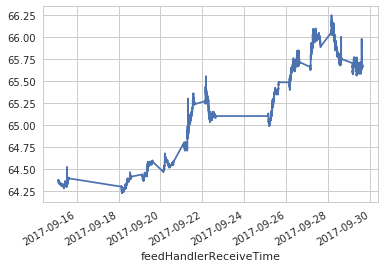

In [10]:
prices['ask'].plot()

Plotting the following descriptive statistics :<br>
>the number of prices updates per day<br>
>the number of reported trades per day<br>
>the daily average price level<br>
>the daily average visible liquidity on the first 2 levels of the orderbook<br>
>the mid price for a specific date (2017.09.15)

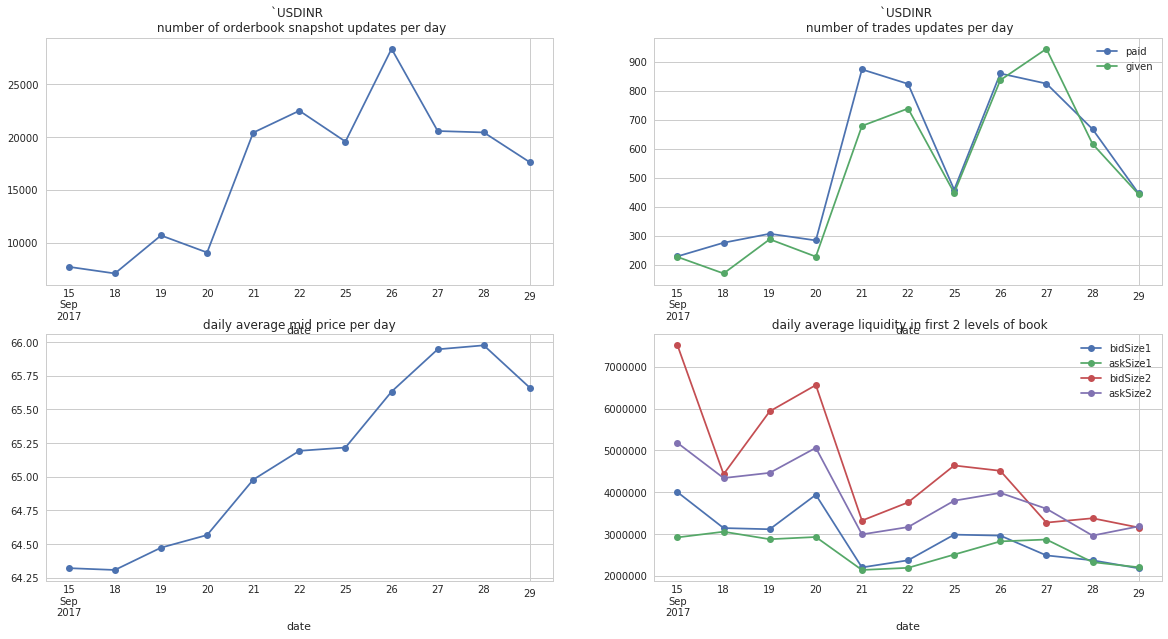

In [115]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
prices.groupby('date')['mid'].count().plot(ax = axes[0,0],title = sym+' \n number of orderbook snapshot updates per day', style = 'o-')
prices.groupby('date')['paid','given'].count().plot(ax = axes[0,1],title = sym+' \n number of trades updates per day', style = 'o-')
prices.groupby('date')['mid'].mean().plot(ax = axes[1,0],title = 'daily average mid price per day', style = 'o-')
prices.groupby('date')[['bidSize1','askSize1','bidSize2','askSize2']].mean().plot(ax = axes[1,1],title = ' daily average liquidity in first 2 levels of book', style = 'o-')
plt.show()

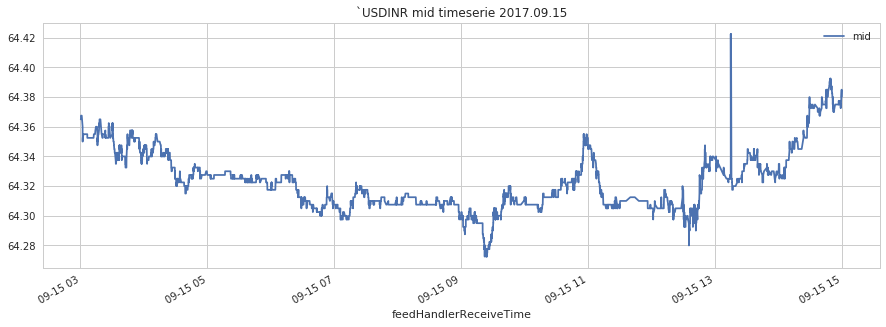

In [116]:
date = '2017.09.15'
prices['date'] = pd.to_datetime(prices.date)
prices[prices['date']==date][['mid']].plot(figsize=(15,5), title=sym+ ' mid timeserie '+date)
plt.show()

## Features Engineering

Our problem is a supervised learning classification problem. The features are derived values of the order book delta updates along with transformation of market trades.

Include the orderbook deltas

In [117]:
columns = ['bid','ask','bid2','ask2','bidSize1','askSize1','bidSize2','askSize2','mid', 'spread']
prices_delta = prices[columns] - prices[columns].shift(1)
prices_delta.rename(columns = {'mid':'deltaMid','bid':'deltaBid','ask':'deltaAsk', 'spread':'deltaSpread','bidSize1':'deltaBidSize1','askSize1':'deltaAskSize1',
                              'bidSize2':'deltaBidSize2','askSize2':'deltaAskSize2'}, inplace=True)

# add back old prices, and a midDiff for learning later
LL = ['mid','bid','ask','bidSize1','bidSize2','askSize1','askSize2','spread']
prices_delta[LL] = prices[LL]
prices_delta['midDiffInterval'] = (prices_delta['deltaMid'] != 0).cumsum()

# drop some features
LLL = ['bid2','ask2','bidSize2','askSize2','deltaBidSize2','deltaAskSize2']
for l in LLL:
    prices_delta.drop(l,1,inplace=True)

Verify the resulting prices and values

In [118]:
prices_delta.head(10)

,deltaBid,deltaAsk,deltaBidSize1,deltaAskSize1,deltaMid,deltaSpread,mid,bid,ask,bidSize1,askSize1,spread,midDiffInterval
feedHandlerReceiveTime,,,,,,,,,,,,,
2017-09-15 03:00:15.341,NaN,NaN,NaN,NaN,NaN,NaN,64.3650,64.360,64.370,1000000,1000000,0.010,1
2017-09-15 03:00:15.841,0.000,0.000,0.0,0.0,0.0000,0.000,64.3650,64.360,64.370,1000000,1000000,0.010,1
2017-09-15 03:00:24.594,0.000,0.000,0.0,0.0,0.0000,0.000,64.3650,64.360,64.370,1000000,1000000,0.010,1
2017-09-15 03:00:25.595,0.000,0.000,0.0,0.0,0.0000,0.000,64.3650,64.360,64.370,1000000,1000000,0.010,1
2017-09-15 03:00:26.094,0.005,0.000,0.0,0.0,0.0025,-0.005,64.3675,64.365,64.370,1000000,1000000,0.005,2
2017-09-15 03:00:27.093,0.000,0.000,0.0,0.0,0.0000,0.000,64.3675,64.365,64.370,1000000,1000000,0.005,2
2017-09-15 03:00:28.842,0.000,0.000,1000000.0,0.0,0.0000,0.000,64.3675,64.365,64.370,2000000,1000000,0.005,2
2017-09-15 03:00:46.841,0.000,0.000,0.0,0.0,0.0000,0.000,64.3675,64.365,64.370,2000000,1000000,0.005,2
2017-09-15 03:01:12.093,0.000,0.000,0.0,0.0,0.0000,0.000,64.3675,64.365,64.370,2000000,1000000,0.005,2


We calculate the following __features__ : <br> 
>the distance between the last traded price and the current mid<br>
>the top of book sizes<br>
>the prior mid variation<br>
>the prior top of book size variation<br>
>a book pressure signal<br>
>the bid-offer spread<br>

In [208]:
prices = prices_raw[['date','bid','ask','bid2','ask2','bid3','ask3','bidSize1','askSize1','bidSize2','askSize2','bidSize3','askSize3','paid', 'given']]

prices['bid'] = prices['bid'].replace(0,np.NaN)
prices['ask'] = prices['ask'].replace(0,np.NaN)
prices['bid2'] = prices['bid2'].replace(0,np.NaN)
prices['ask2'] = prices['ask2'].replace(0,np.NaN)

prices['paid'] = prices['paid'].replace(0,np.NaN)
prices['given'] = prices['given'].replace(0,np.NaN)
prices['mid'] =  prices['ask']
prices['mid'] = 0.5*(prices['bid'] + prices['mid'])

prices['spread'] = prices['ask'] - prices['bid']

prices.index = prices_raw.feedHandlerReceiveTime
prices=prices.drop_duplicates()
date = '2017.09.15'
prices['date'] = pd.to_datetime(prices.date)

columns = ['bid','ask','bid2','ask2','bidSize1','askSize1','bidSize2','askSize2','mid', 'spread']
prices_delta = prices[columns] - prices[columns].shift(1)
prices_delta.rename(columns = {'mid':'deltaMid','bid':'deltaBid','ask':'deltaAsk', 'spread':'deltaSpread','bidSize1':'deltaBidSize1','askSize1':'deltaAskSize1',
                              'bidSize2':'deltaBidSize2','askSize2':'deltaAskSize2'}, inplace=True)

# add back old prices, and a midDiff for learning later
LL = ['mid','bid','ask','bidSize1','bidSize2','askSize1','askSize2','spread']
prices_delta[LL] = prices[LL]
prices_delta['midDiffInterval'] = (prices_delta['deltaMid'] != 0).cumsum()

# drop some features
LLL = ['bid2','ask2','bidSize2','askSize2','deltaBidSize2','deltaAskSize2']
for l in LLL:
    prices_delta.drop(l,1,inplace=True)

    

# time feature (on feedHandlerRecieve), date,time ... 
prices_delta['date'] = prices.date
prices_delta['time'] = prices.index

# trade Features, print,tradeSeq,lastPaid,lastGiven,bidToPaid,bidToGiven,midToPaid ...
atomicTrades = prices[['paid','given']].loc[(prices['paid']>1) | (prices['given']>1)]
atomicTrades.loc[atomicTrades['paid'] <1, 'paid' ] = np.NaN
atomicTrades.loc[atomicTrades['given'] <1, 'given' ] = np.NaN
atomicTrades = atomicTrades.replace(0,np.NaN)
prices_delta['paid'] = atomicTrades['paid']
prices_delta['given'] = atomicTrades['given']
prices_delta['print'] = np.where((prices_delta['paid']>1) | (prices_delta['given']>1),1,0)
prices_delta['tradeSeq'] = prices_delta['print'].cumsum()
prices_delta['lastPaid'] = prices_delta['paid'].ffill()
prices_delta['lastGiven'] = prices_delta['given'].ffill()
prices_delta.drop('paid',1,inplace=True)
prices_delta.drop('given',1,inplace=True)
prices_delta['midToPaid'] = prices_delta['mid'] - prices_delta['lastPaid']
prices_delta['midToGiven'] = prices_delta['mid'] - prices_delta['lastGiven']
prices_delta['bidToPaid'] = prices_delta['bid'] - prices_delta['lastPaid']
prices_delta['bidToGiven'] = prices_delta['bid'] - prices_delta['lastGiven']
prices_delta['askToPaid'] = prices_delta['ask'] - prices_delta['lastPaid']
prices_delta['askToGiven'] = prices_delta['ask'] - prices_delta['lastGiven']

# book preasure feature
prices['book_pressure'] = prices['mid'] - (prices['bidSize1']*prices['bid'] + prices['askSize1']*prices['ask'])/(prices['bidSize1']+prices['askSize1'])
prices['book_pressure_with2'] = prices['mid'] - (prices['bidSize1']*prices['bid'] + prices['askSize1']*prices['ask']
                                                 + prices['askSize2']*prices['ask2'] + prices['askSize3']*prices['ask3']
                                                 + prices['bidSize2']*prices['bid2'] + prices['bidSize3']*prices['bid3'])/(prices['bidSize1']+prices['askSize1']+prices['bidSize2']+prices['askSize2']+prices['bidSize3']+prices['askSize3'])

prices_delta['book_pressure'] = prices['mid'] - (prices['bidSize1']*prices['bid'] + prices['askSize1']*prices['ask'])/(prices['bidSize1']+prices['askSize1'])
prices_delta['book_pressure_with2'] = prices['book_pressure_with2']

# spread feature
prices_delta['spread'] = prices_delta['ask'] - prices_delta['bid']

#timestamp
prices_delta['weekday'] = prices_delta['time'].dt.weekday
#prices_delta['daytimestamp'] = prices_delta['time'].dt.timestamp

# moving averages
prices_delta['mid_ma3orders'] = prices_delta['mid'].rolling(3).mean()
prices_delta['mid_ma5orders'] = prices_delta['mid'].rolling(5).mean()
prices_delta['mid_ma10orders'] = prices_delta['mid'].rolling(10).mean()

# moving averages seconds
prices_delta['mid_ma0.03s'] = prices_delta['mid'].rolling('30ms').mean()
prices_delta['mid_ma0.05s'] = prices_delta['mid'].rolling('50ms').mean()
prices_delta['mid_ma0.3s'] = prices_delta['mid'].rolling('300ms').mean()
prices_delta['mid_ma0.5s'] = prices_delta['mid'].rolling('500s').mean()
prices_delta['mid_ma1s'] = prices_delta['mid'].rolling('1s').mean()
prices_delta['mid_ma2s'] = prices_delta['mid'].rolling('2s').mean()
#prices_delta['mid_ma3s'] = prices_delta['mid'].rolling('3s').mean()
prices_delta['mid_ma5s'] = prices_delta['mid'].rolling('5s').mean()
prices_delta['mid_ma50s'] = prices_delta['mid'].rolling('50s').mean()


# volatiltity, EOD, BOD

# PCA




# create feature to learn, ie next move (not to be used as covariates!)
prices_delta['midDiff'] = prices_delta['mid'].diff()
prices_delta['nextMidDiff'] = prices_delta['midDiff'].shift(-1)
prices_delta['nextMidVariation'] = prices_delta['nextMidDiff'].replace(to_replace=0, method='bfill')

prices_delta.dropna(inplace=True)
prices_delta.head()

,deltaBid,deltaAsk,deltaBidSize1,deltaAskSize1,deltaMid,deltaSpread,mid,bid,ask,bidSize1,askSize1,spread,midDiffInterval,date,time,print,tradeSeq,lastPaid,lastGiven,midToPaid,midToGiven,bidToPaid,bidToGiven,askToPaid,askToGiven,book_pressure,book_pressure_with2,weekday,mid_ma3orders,mid_ma5orders,mid_ma10orders,mid_ma0.03s,mid_ma0.05s,mid_ma0.3s,mid_ma0.5s,mid_ma1s,mid_ma2s,mid_ma5s,mid_ma50s,midDiff,nextMidDiff,nextMidVariation
feedHandlerReceiveTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-15 03:13:39.842,0.000,0.0,0.0,-1000000.0,0.0000,0.000,64.3550,64.345,64.365,2000000,2000000,0.020,8,2017-09-15,2017-09-15 03:13:39.842,1,2,64.365,64.36,-0.0100,-0.0050,-0.020,-0.015,0.0,0.005,-1.421085e-14,-0.000625,4,64.355000,64.3550,64.35375,64.3550,64.3550,64.3550,64.353625,64.3550,64.3550,64.3550,64.355000,0.0000,0.0000,0.0025
2017-09-15 03:13:40.841,0.000,0.0,0.0,0.0,0.0000,0.000,64.3550,64.345,64.365,2000000,2000000,0.020,8,2017-09-15,2017-09-15 03:13:40.841,0,2,64.365,64.36,-0.0100,-0.0050,-0.020,-0.015,0.0,0.005,-1.421085e-14,-0.003333,4,64.355000,64.3550,64.35400,64.3550,64.3550,64.3550,64.353690,64.3550,64.3550,64.3550,64.355000,0.0000,0.0000,0.0025
2017-09-15 03:13:44.841,0.000,0.0,0.0,0.0,0.0000,0.000,64.3550,64.345,64.365,2000000,2000000,0.020,8,2017-09-15,2017-09-15 03:13:44.841,0,2,64.365,64.36,-0.0100,-0.0050,-0.020,-0.015,0.0,0.005,-1.421085e-14,-0.002222,4,64.355000,64.3550,64.35425,64.3550,64.3550,64.3550,64.353690,64.3550,64.3550,64.3550,64.355000,0.0000,0.0025,0.0025
2017-09-15 03:14:05.592,0.005,0.0,-1000000.0,0.0,0.0025,-0.005,64.3575,64.350,64.365,1000000,2000000,0.015,9,2017-09-15,2017-09-15 03:14:05.592,0,2,64.365,64.36,-0.0075,-0.0025,-0.015,-0.010,0.0,0.005,-2.500000e-03,-0.001875,4,64.355833,64.3555,64.35475,64.3575,64.3575,64.3575,64.353750,64.3575,64.3575,64.3575,64.355625,0.0025,0.0025,0.0025
2017-09-15 03:14:33.842,0.005,0.0,0.0,0.0,0.0025,-0.005,64.3600,64.355,64.365,1000000,2000000,0.010,10,2017-09-15,2017-09-15 03:14:33.842,0,2,64.365,64.36,-0.0050,0.0000,-0.010,-0.005,0.0,0.005,-1.666667e-03,0.000000,4,64.357500,64.3565,64.35550,64.3600,64.3600,64.3600,64.354048,64.3600,64.3600,64.3600,64.357500,0.0025,0.0000,-0.0050


Let's review the processed data. the matrix of features is sparse. We replace all zeros by NaN tocalculate meaningful statistics using pandas.

In [120]:
prices_delta = prices_delta.replace(0,np.NaN)

We remove the prices variations outliers using __stats__ in __scipy__ 

In [121]:
prices_delta = prices_delta.replace(np.NaN,0)
prices_delta_clean = prices_delta[(np.abs(stats.zscore(prices_delta['deltaMid'])) < 5)]
prices_delta_clean = prices_delta_clean.replace(0,np.NaN)
prices_delta_clean = prices_delta_clean.replace(np.NaN,0)

Let's label the dataset and train a classification learning algorithm.

In [123]:
features = ['deltaBid','deltaAsk','deltaMid','midToPaid','midToGiven','bidSize1','askSize1','bidToPaid','askToGiven','bidToGiven','askToPaid', 'book_pressure','spread', 'book_pressure_with2']

OUT = (prices_delta_clean.date == '2017.09.29') | (prices_delta_clean.date == '2017.09.28') 
OUT = OUT | (prices_delta_clean.date == '2017.09.27') 
IN = ~OUT

X_train = np.array(prices_delta_clean[IN][features].values)
y_train = np.array(prices_delta_clean[IN]['nextMidVariation'].values)
X_test = np.array(prices_delta_clean[OUT][features].values)
y_test = np.array(prices_delta_clean[OUT]['nextMidVariation'].values)

y_train[y_train<0] = -1
y_train[y_train>0] = 1
y_test[y_test<0] = -1
y_test[y_test>0] = 1

## Fitting a Predictive Model

In [166]:
prices_delta['time'].dt.to_timestamp()

AttributeError: 'DatetimeProperties' object has no attribute 'to_timestamp'

In [190]:
help(prices_delta)

Help on DataFrame in module pandas.core.frame object:

class DataFrame(pandas.core.generic.NDFrame)
 |  Two-dimensional size-mutable, potentially heterogeneous tabular data
 |  structure with labeled axes (rows and columns). Arithmetic operations
 |  align on both row and column labels. Can be thought of as a dict-like
 |  container for Series objects. The primary pandas data structure.
 |  
 |  Parameters
 |  ----------
 |  data : numpy ndarray (structured or homogeneous), dict, or DataFrame
 |      Dict can contain Series, arrays, constants, or list-like objects
 |  
 |      .. versionchanged :: 0.23.0
 |         If data is a dict, argument order is maintained for Python 3.6
 |         and later.
 |  
 |  index : Index or array-like
 |      Index to use for resulting frame. Will default to RangeIndex if
 |      no indexing information part of input data and no index provided
 |  columns : Index or array-like
 |      Column labels to use for resulting frame. Will default to
 |      Ra

In [198]:
prices_delta['mid'].rolling('2s').mean()

feedHandlerReceiveTime
2017-09-15 03:00:15.341    64.365000
2017-09-15 03:00:15.841    64.365000
2017-09-15 03:00:24.594    64.365000
2017-09-15 03:00:25.595    64.365000
2017-09-15 03:00:26.094    64.365833
2017-09-15 03:00:27.093    64.366667
2017-09-15 03:00:28.842    64.367500
2017-09-15 03:00:46.841    64.367500
2017-09-15 03:01:12.093    64.367500
2017-09-15 03:02:01.092    64.360000
2017-09-15 03:02:02.091    64.355000
2017-09-15 03:02:03.092    64.350000
2017-09-15 03:02:05.092    64.352500
2017-09-15 03:02:06.092    64.352500
2017-09-15 03:02:07.842    64.352500
2017-09-15 03:02:55.587    64.355000
2017-09-15 03:05:22.837    64.355000
2017-09-15 03:05:26.087    64.355000
2017-09-15 03:05:40.336    64.355000
2017-09-15 03:06:26.337    64.355000
2017-09-15 03:06:27.837    64.353750
2017-09-15 03:06:28.090    64.353333
2017-09-15 03:07:19.341    64.352500
2017-09-15 03:09:01.591    64.352500
2017-09-15 03:09:30.342    64.352500
2017-09-15 03:09:31.341    64.352500
2017-09-15 03:1

In [195]:
prices_delta['mid']

feedHandlerReceiveTime
2017-09-15 03:00:15.341    64.3650
2017-09-15 03:00:15.841    64.3650
2017-09-15 03:00:24.594    64.3650
2017-09-15 03:00:25.595    64.3650
2017-09-15 03:00:26.094    64.3675
2017-09-15 03:00:27.093    64.3675
2017-09-15 03:00:28.842    64.3675
2017-09-15 03:00:46.841    64.3675
2017-09-15 03:01:12.093    64.3675
2017-09-15 03:02:01.092    64.3600
2017-09-15 03:02:02.091    64.3500
2017-09-15 03:02:03.092    64.3500
2017-09-15 03:02:05.092    64.3525
2017-09-15 03:02:06.092    64.3525
2017-09-15 03:02:07.842    64.3525
2017-09-15 03:02:55.587    64.3550
2017-09-15 03:05:22.837    64.3550
2017-09-15 03:05:26.087    64.3550
2017-09-15 03:05:40.336    64.3550
2017-09-15 03:06:26.337    64.3550
2017-09-15 03:06:27.837    64.3525
2017-09-15 03:06:28.090    64.3525
2017-09-15 03:07:19.341    64.3525
2017-09-15 03:09:01.591    64.3525
2017-09-15 03:09:30.342    64.3525
2017-09-15 03:09:31.341    64.3525
2017-09-15 03:10:21.592    64.3525
2017-09-15 03:10:57.594    64.35